캐스케이드 분류기와 얼굴 검출  
얼굴만 검출하는것이 아닌 눈 검출 등 여러가지 검출할 수 있는 학습가능하다. 24by24 크기로 정규화했다. 최소 얼굴크기가 24by24는 되어야 한다는 뜻이다. 이 알고리즘에서 **부스팅(boosting), cascade classifier 알고리즘, Haar-like filter 필터**이다.

# Haar like filter
흑백 사각형이 서로 붙어 있는 형태로 구성된 필터
원래 이미지에 필터를 통과시킨 것이다. 필터의 값이 딱 두가지이다. 1과 -1이다.   
같은 필터임에도 엄청 많이 존재할 수 있다. 
사람의 정면 얼굴 형태가 전형적으로 밝은 영역(이마, 미간, 볼 등)과 어두운 영역(눈썹, 입술, 등)이 정해져 있다.
**동일한 필터인데 24by24 크기가 -1(빼고) 1(더하고) 0(무시)** 

하라이크 필터로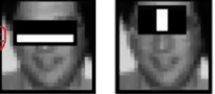 눈쪽과 콧대등을 검출할 수 있다.  
원리 필터와 원래 이미지가 유사하면 값이 크게나오고 다르면 작게나온다. 이런식으로 인식하는 방법이다. 

# Integral Image
Haar Like를 고속으로 계산하는 방법이다.  
24by24에서 필터를 연산하기 떄문에 24by24만큼의 덧셈과 곱셈이 필요하다. 많은 연산이 필요하다. 사진에서 얼굴이 어디에 있을지 모르고 크기가 어떨지 모르기 때문에 고속으로 연산할 필요가 있다. 
1. C까지계산한 것에서 B까지, D까지를 뺀다. 그리고 중복된 A를 다시 더한다.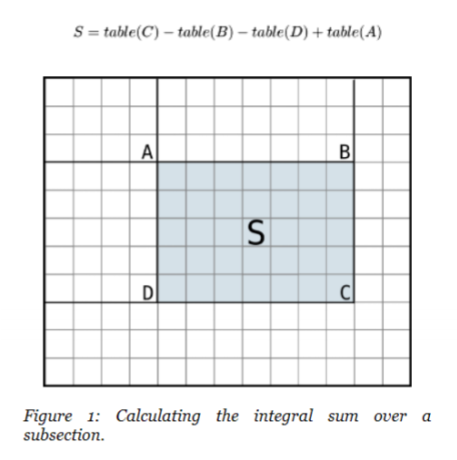 그렇게 되면 전체 S값을 구할 수 있다.

Integral Image를 만든다 . 
누적해서 더한다.  
C+A-B-D로 더한다. Integral Image가 한번 되어있으면 100번의 덧셈도 단 4번의 연산으로 수행할 수 있다.



# AdaBoost
+와 -영역.  
+와 -를 직선하나로 구분할 수는 없다. 선형이아니라 비선형이기 때문에 그렇다. 기본적으로 간단한 분류기여러개를 조합해서 복잡한 분류문제를 풀겠다. 

weak classifier를 조합한다.
Iteration1 당 각각 +영역과 -영역을 도출합니다. 따라서 각각의 분류기에서 다수결원칙으로 높은의견으로 정한다.

하지만 각각의 오류가 다르기 떄문에 가중치를 다르게 한다. 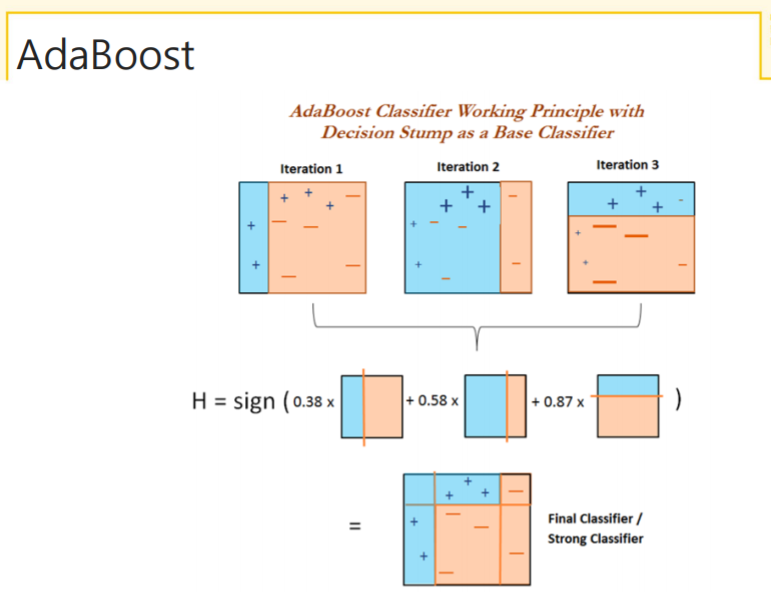

# 비올라와 존스  
대부분의 영상에 얼굴이 한 두개이며 나머지 대부분은 얼굴이 아니다.   
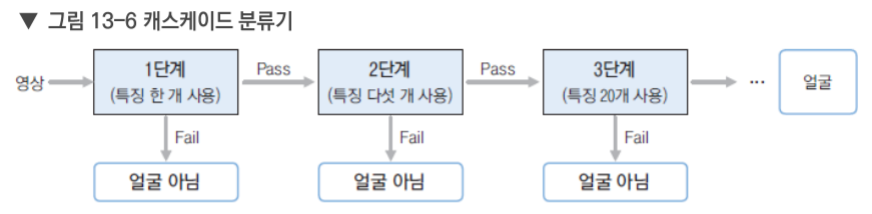


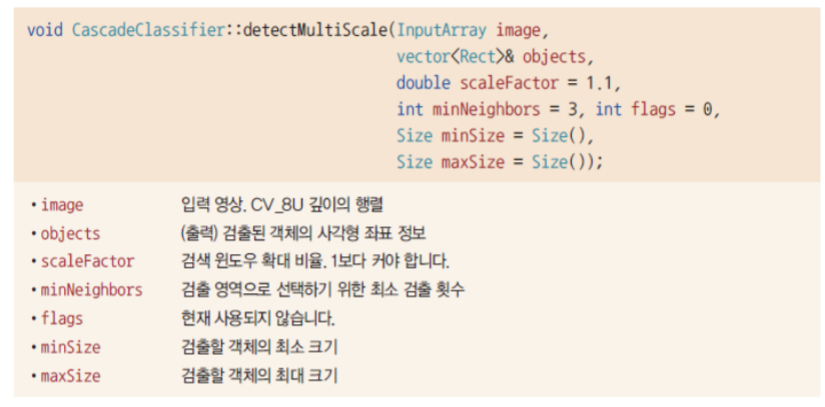
minNeighbors : 검출 영역으로 선택하기 위한 최소 검출 횟수 숫자가 높을수록 검출률이 낮을 것이다

얼굴을 검출하기 위해서 Integral Image와 AdaBoost 알고리즘을 어떻게 적용하는지 설명하시오.

HoG특징 추출에 의해 사람 영상은 3780개의 특징값으로 벡터로 표현된다. 

3780개 특징이 어떻게 계산되는지 설명하시오.

In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt
import random
import math 
!pip install opencv-python

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")   

# 1. Haar-like 얼굴 검출

In [2]:
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

src = cv2.imread('kids.png')

faces = classifier.detectMultiScale(src)
print(faces)

[[113 158 112 112]
 [504 145 126 126]]


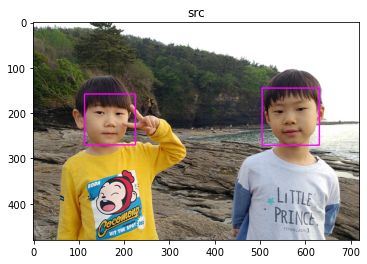

In [3]:
for (x, y, w, h) in faces:
        cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)

imshow('src', src)

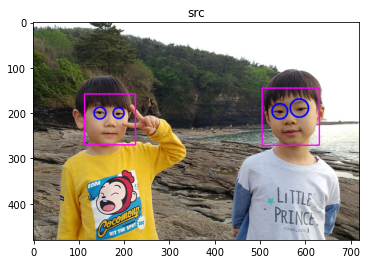

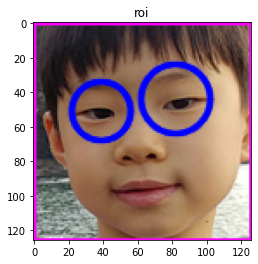

In [4]:
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('haarcascade_eye.xml')


src = cv2.imread('kids.png')

faces = face_classifier.detectMultiScale(src)

for (x1, y1, w1, h1) in faces:
        cv2.rectangle(src, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)

        faceROI = src[y1:y1 + h1, x1:x1 + w1]
        eyes = eye_classifier.detectMultiScale(faceROI)

        for (x2, y2, w2, h2) in eyes:
            center = (int(x2 + w2 / 2), int(y2 + h2 / 2))
            cv2.circle(faceROI, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)

imshow('src', src); plt.show()
imshow("roi", faceROI)

# 2. HoG 기반 보행자 검출

Histograms of Oriented Gradients  
에지의 방향에는 크기와 각도가있다. 여기서 크기는 고려하지않고 방향성분만 고려해 히스토그램을 구한다.

0~ 19도는 0으로 20~ 39는 1로 바꾼다.  이렇게 20도로 나누기때문에 전체 9개만나온다. 따라서 0~19가 5개 20~39가 7개 이런식으로 0~8이 몇개인지 구할 수 있다. 

노란색 실선은 셀(8by8), 빨간색 사각형은 블록하나를 나타낸다.  
블록은 가로와 세로 방향으로 각각 한개의 셀만큼 이동하면서 정의한다. 
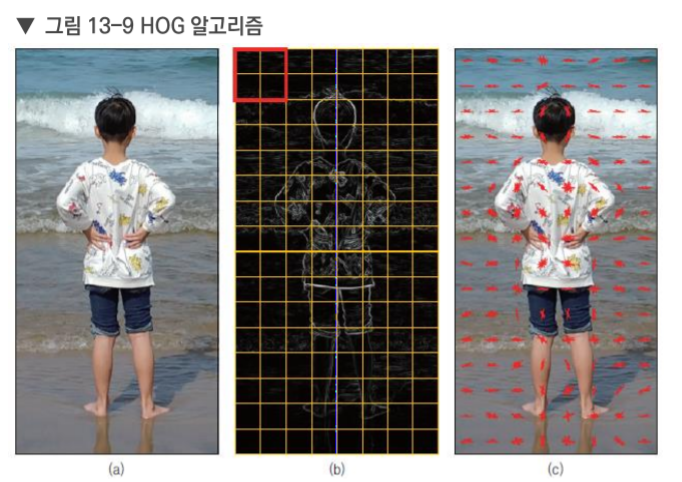
총 영상에서 64by128에서는 105개이다. 7x15이다.이며  
36은 하나의 블럭은 4개의 셀, 그리고 각각의 셀은 9개의 값으로 구성되어있기 때문이다.   
따라서 105개의 블록, 각각의 블록은 4개의 셀, 각각의 셀은 9개의 값을 가지고 있다.  
따라서 64 x 128영상에는 3780개의 히스토그램 정보를 가지고 있다. 이것을 통해 SVM 분류기에서 분류할 수 있다.

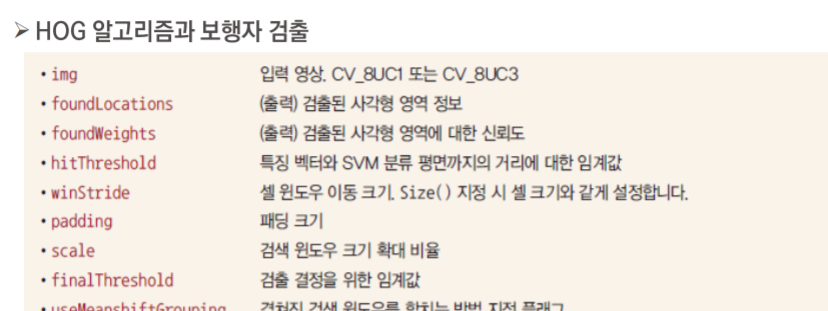  

회전되지 않은 서있는 보행자만 검출할 수 있다.

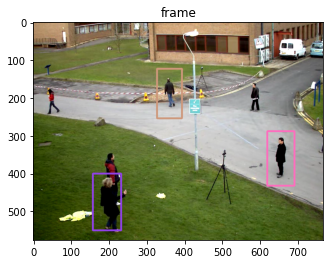

In [5]:
frame = cv2.imread('vtest.png')

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

detected, _ = hog.detectMultiScale(frame)

for (x, y, w, h) in detected:
        c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.rectangle(frame, (x, y), (x + w, y + h), c, 3)

imshow('frame', frame)

In [6]:
cap = cv2.VideoCapture('vtest.avi')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

while True:
    ret, frame = cap.read()

    if not ret:
        break

    detected, _ = hog.detectMultiScale(frame)

    for (x, y, w, h) in detected:
        c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.rectangle(frame, (x, y), (x + w, y + h), c, 3)

    cv2.imshow('frame', frame)
    if cv2.waitKey(10) == 27:
        break
cv2.destroyAllWindows()

# QR 코드

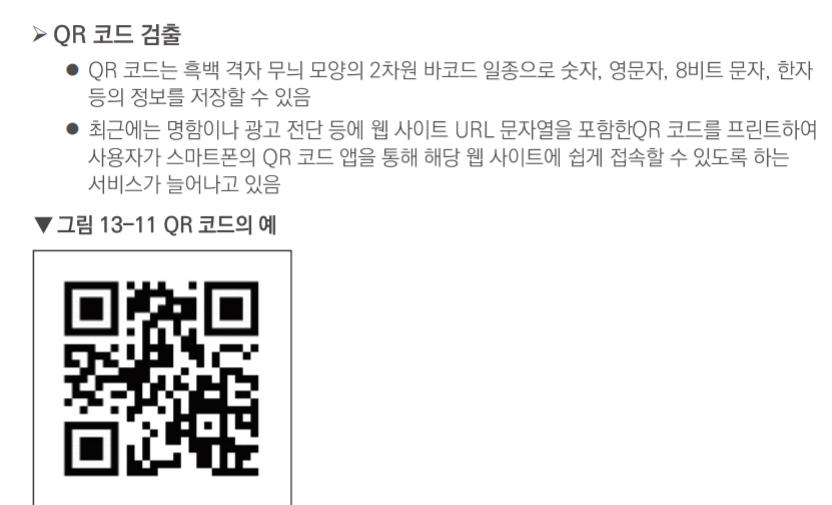  
바코드는 순자, 문자열을 넣으려면 QR코드정도는 써주어야한다.  
1. qr코드를 어디에 있는지 검출
2. 안에있는 내용을 해석하는 디코딩 기술 

In [7]:
detector = cv2.QRCodeDetector()

frame = cv2.imread('qrcode.png')
info, points, _ = detector.detectAndDecode(frame)
#한번에 디텍트하고 검출하는 함수 qr코드 생성 프로그램
print(info)
print(points)

Hello, OpenCV 4.0!!!
[[[ 37.  37.]
  [261.  37.]
  [261. 261.]
  [ 37. 261.]]]


QR Code Generator

[[ 37  37]
 [261  37]
 [261 261]
 [ 37 261]]
Hello, OpenCV 4.0!!!


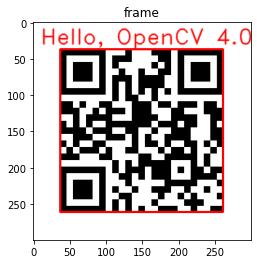

In [8]:
points = np.array(points, dtype=np.int32).reshape(4, 2)
print(points)

cv2.polylines(frame, [points], True, (0, 0, 255), 2)

print(info)

cv2.putText(frame, info, (10, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 255), lineType=cv2.LINE_AA)

imshow('frame', frame)

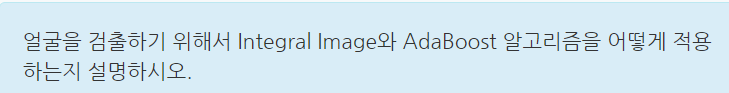
Integral Image : Haar Like 를 고속으로 계산하는 방법이다.

24by24에서 필터를 연산할경우 24by24만큼의 덧셈과 곱셈이 필요하므로 매우 많은 연산이 필요하다. 따라서 사진에서 얼굴이 어디에 있을지 모르게 때문에 고속으로 연산할 필요가 있어 Integral Image기법을 사용한다.

1. Integral Image를 생성한다. 각 픽셀값들을 누적해서 더한값을 저장하는 기법이다. 따라서 사각형이 시계방향으로 A,B,C,D있을경우 C+A+B-D 연산하면 네번의 연산으로 계산을 할 수있다. 만약 100픽셀의 이미지의 경우에도 단 네번만 계산하면 되기에 연산처리속도가 빠르다.



2.AdaBoost : Weak Classifier를 조합하는 방법이다. 각각의 Iteration으로 +영역과 -영역을 도출하며 각각의 정확도로 가중치를 부여해준다. 이렇게 각각의 Iteration에서 다수결원칙으로 높은 값을 최종 값으로 결정한다.  

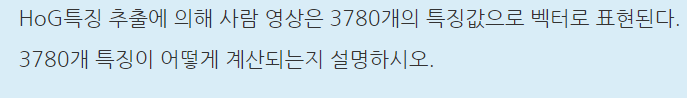
64by128 픽셀의 영상에는 3780개의 특징값들을 도출한다.

영상에는 105개의 블록(가로7x세로15)으로 구성되며 각각의 블록은 4개의 셀, 각각의 셀은 9개의 값을 가진다. 

따라서 64by128 영상에는 블록 수(7 x 15) x 셀 수(4) x bin 값(9) 으로 3780개의 특징값을 도출한다.